In [38]:

import numpy as np
import pandas as pd
global_temp = pd.read_csv("GlobalTemperatures.csv")
print(global_temp.shape)
print(global_temp.columns)
print(global_temp.info())
print(global_temp.isnull().sum())

(3192, 9)
Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   

In [15]:
global_temp.shape

(3192, 9)

In [16]:
#Data Preparation
def wrangle(df):
    df = df.copy()
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)

In [19]:
import pandas as pd

def converttemp(x):
    x = (x * 1.8) + 32
    return float(x)

def wrangle(df):
    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)

    df["dt"] = pd.to_datetime(df["dt"])
    df["Month"] = df["dt"].dt.month
    df["Year"] = df["dt"].dt.year

    df = df.drop(["dt", "Month"], axis=1)
    df = df[df["Year"] >= 1850]
    df = df.set_index(["Year"])
    df = df.dropna()

    return df

# Assuming 'global_temp' is your DataFrame
global_temp = wrangle(global_temp)
print(global_temp.head())


      LandAverageTemperature  LandAverageTemperatureUncertainty  \
Year                                                              
1850                 33.3482                              1.105   
1850                 37.5278                              1.275   
1850                 40.9172                              0.955   
1850                 44.9906                              0.665   
1850                 50.0072                              0.617   

      LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
Year                                                                          
1850             46.8356                          1.738             26.2292   
1850             49.9460                          3.007             27.8762   
1850             50.6246                          2.401             28.5710   
1850             55.2812                          1.004             33.8324   
1850             60.1790                          2.406 

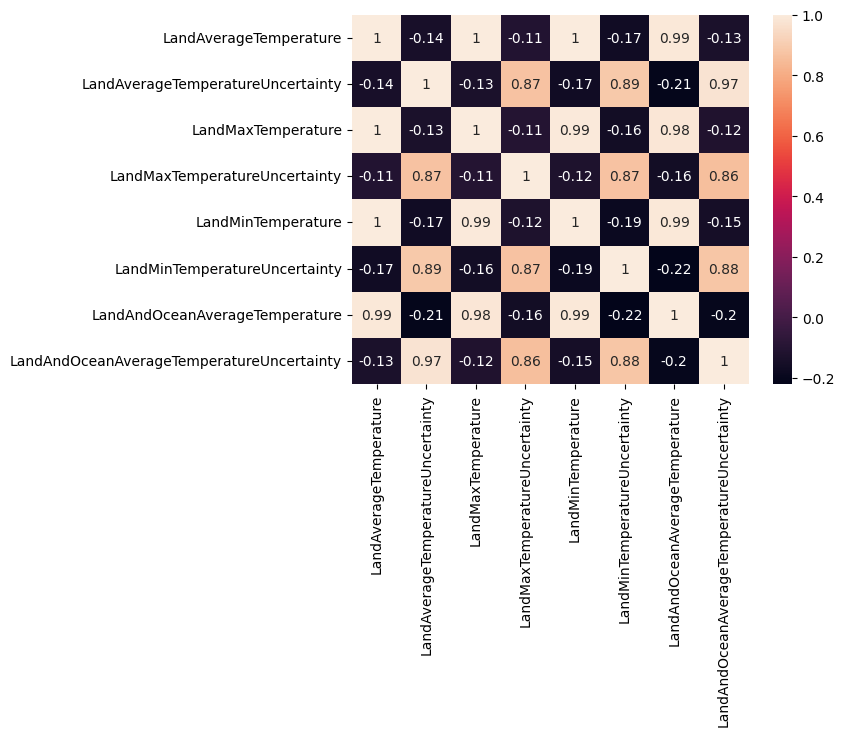

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
corrMatrix = global_temp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [22]:
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
x = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

In [23]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.25, random_state=42)
print(xtrain.shape)
print(xval.shape)
print(ytrain.shape)
print(yval.shape)

(1494, 3)
(498, 3)
(1494,)
(498,)


In [24]:
from sklearn.metrics import mean_squared_error
ypred = [ytrain.mean()] * len(ytrain)
print("Baseline MAE: ", round(mean_squared_error(ytrain, ypred), 5))

Baseline MAE:  5.29374


In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
forest = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)
forest.fit(xtrain, ytrain)

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

In [40]:
import numpy as np

def calculate_mape(ypred, yval):
  """Calculates the Mean Absolute Percentage Error (MAPE).

  Args:
    ypred: Predicted values.
    yval: Actual values.

  Returns:
    MAPE as a percentage.
  """

  if len(ypred) != len(yval):
    raise ValueError("ypred and yval must have the same length")

  errors = np.abs(ypred - yval)
  # Handle division by zero
  valid_indices = np.where(yval != 0)[0]
  mape = 100 * np.mean(errors[valid_indices] / yval[valid_indices])
  return mape

# Example usage:
ypred = np.array([2, 4, 6])
yval = np.array([3, 5, 7])

accuracy = 100 - calculate_mape(ypred, yval)
print("Random Forest Model: ", round(accuracy, 2), "%")


Random Forest Model:  77.46 %
